# <center> Time Series Analysis (TSA) - From Linear Models to GARCH <center>

In [1]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
p = print

Let's use the pandas_datareader package to grab some sample data using the Yahoo Finance API.

In [3]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

## The Basics

### Stationarity

In [4]:
from IPython.display import Image

In [5]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w")

So what?  Why do we care about stationarity? 

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

With that said, most TS we encounter in finance is NOT stationary. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary.

### Serial Correlation (Autocorrelation)

Essentially when we model a time series we decompose the series into three components: trend, seasonal/cyclical, and random. The random component is called the residual or error. It is simply the difference between our predicted value(s) and the observed value(s). Serial correlation is when the residuals (errors) of our TS models are correlated with each other.

We care about serial correlation because it is critical for the validity of our model predictions, and is intrinsically related to stationarity. Recall that the residuals (errors) of a stationary TS are serially uncorrelated by definition. If we fail to account for this in our models the standard errors of our coefficients are underestimated, inflating the size of our T-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True. In layman's terms, ignoring autocorrelation means our model predictions will be bunk, and we're likely to draw incorrect conclusions about the impact of the independent variables in our model. 

### White Noise and Random Walks

White noise is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially **UNcorrelated errors** and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it. Below I introduce a convenience function for plotting the time series and analyzing the serial correlation visually.

In [6]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

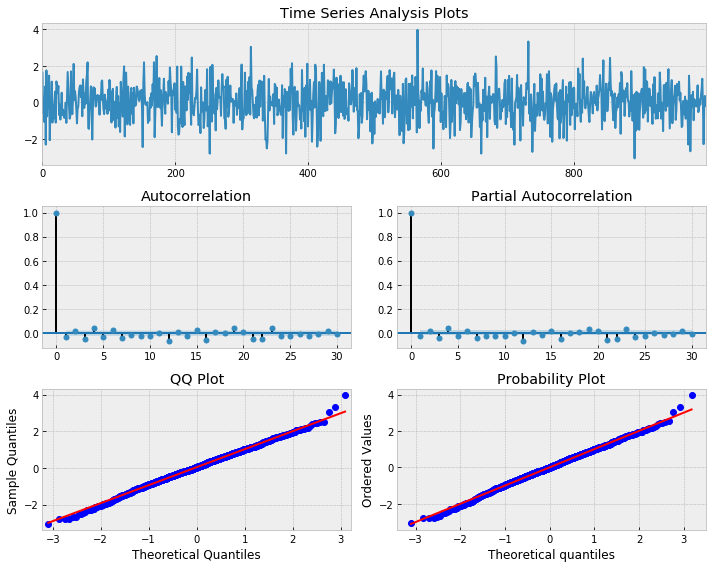

In [7]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

### Random Walk

In [8]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818eca637c5813ad8dd9d30/1478028494315/?format=750w")

The significance of a random walk is that it is non-stationary because the covariance between observations is time-dependent. If the TS we are modeling is a random walk it is unpredictable.

Let's simulate a random walk using the "numpy.random.normal(size=our_sample_size)" function to sample from the standard normal distribution. 

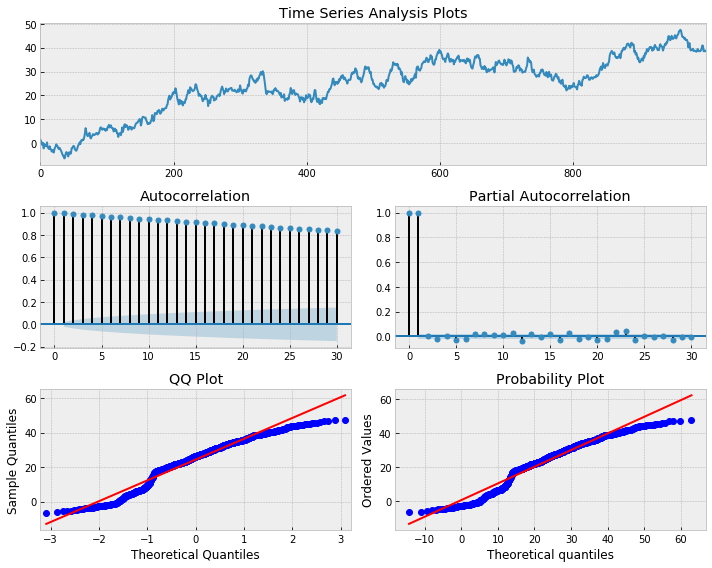

In [9]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. Let's find out if the random walk model is a good fit for our simulated data. Recall that a random walk is xt = xt-1 + wt. Using algebra we can say that xt - xt-1 = wt. Thus the first differences of our random walk series should equal a white noise process! We can use the "np.diff()" function on our TS and see if this holds. 

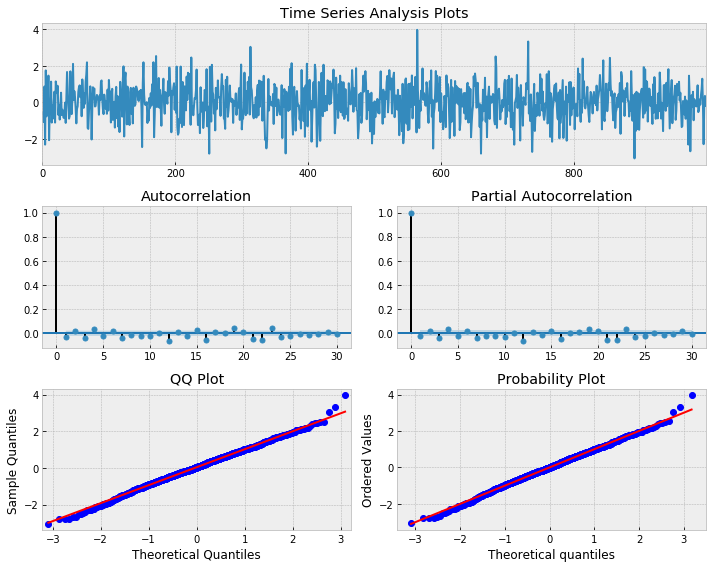

In [10]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

Our definition holds as this looks exactly like a white noise process. What if we fit a random walk to the first difference of SPY's prices?

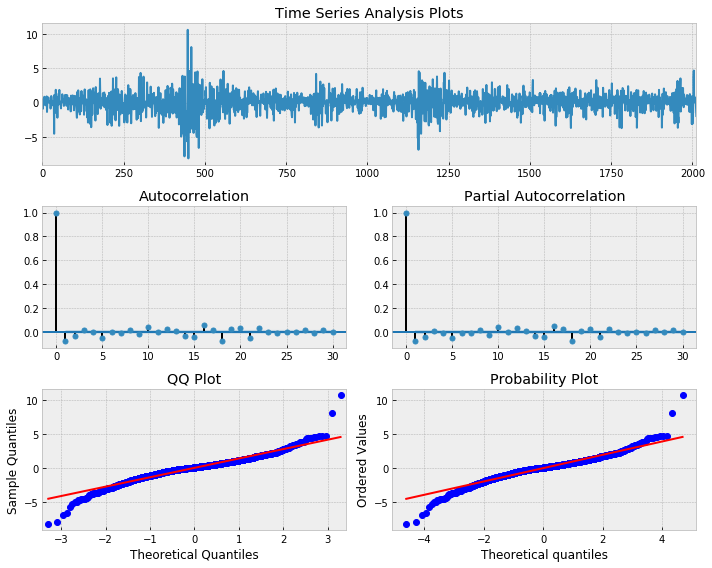

In [11]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30)

Wow, it's quite similar to white noise. However, notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5?, 16?, 18 and 21. This means that there should be better models to describe the actual price change process. 

## Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:

In [12]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/581a1056197aea1a94d28e59/1478103140567/?format=300w")

In this model the value of the dependent variable is determined by the beta coefficients and a singular independent variable, time.

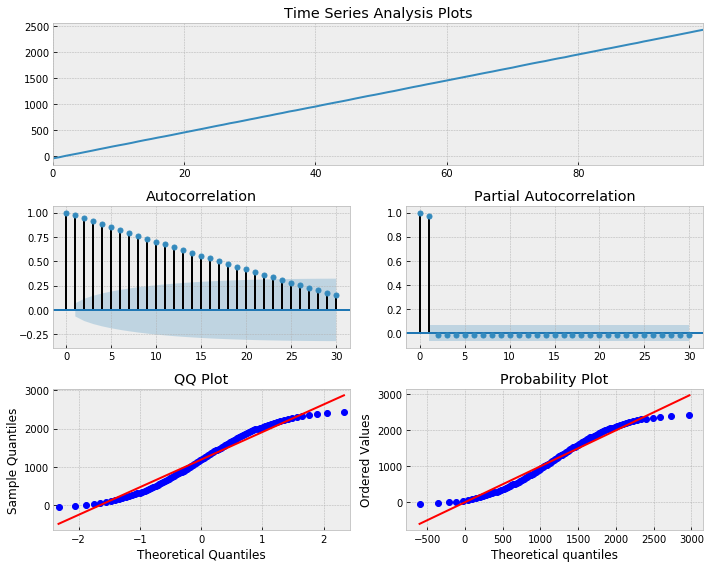

In [13]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)  

Here we can see that the residuals of the model are correlated and linearly decreasing as a function of the lag. The distribution is approximately normal. Before using this model to make predictions we would have to account for and remove the obvious autocorrelation present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate.

## Log-Linear Models

These models are similar to linear models except that the data points form an exponential function that represent a constant rate of change with respect to each time step.

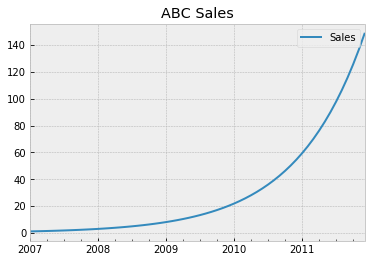

In [14]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

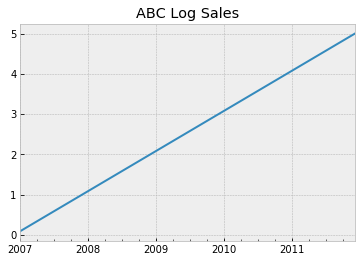

In [15]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

**These models have a fatal weakness. They assume serially UNcorrelated errors, which as we have seen in the linear model example is not true. In real life, TS data usually violates our stationary assumptions which motivates our progression to autoregressive models.**

## Autoregressive Models - AR(p)

When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive. The formula looks like this:

In [16]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/581a3a9f8419c21ac8e1a14a/1478113959326/?format=500w")

Let's simulate an AR(1) model with alpha set equal to 0.6

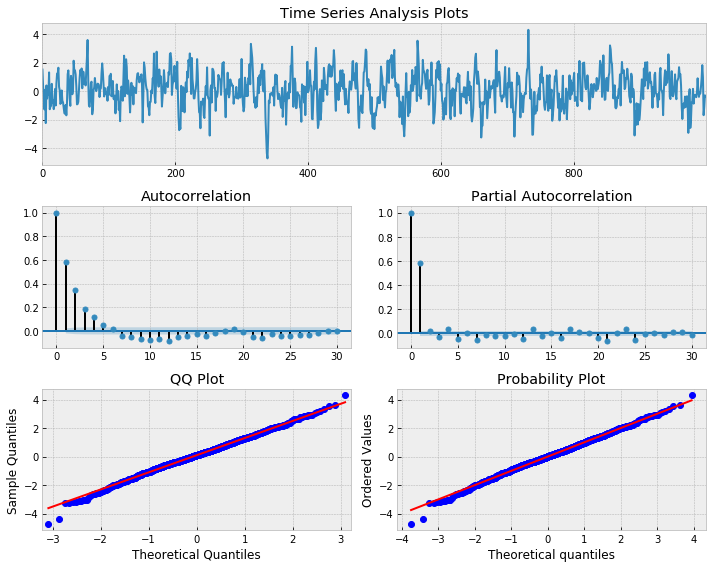

In [17]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [18]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

Wall time: 13.3 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Not bad. Let's see how the AR(p) model will fit MSFT log returns. Here is the return TS.

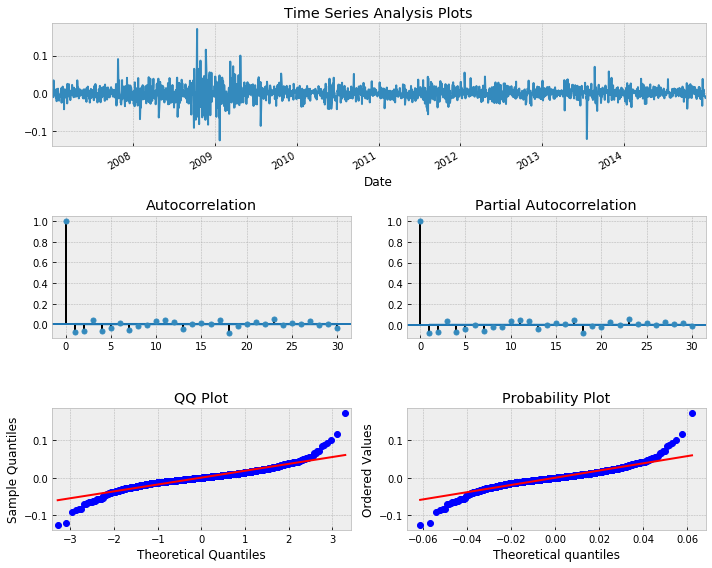

In [19]:
_ = tsplot(lrets.MSFT, lags=30)

In [20]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

best estimated lag order = 23


The best order is 23 lags or 23 parameters! Any model with this many parameters is unlikely to be useful in practice. Clearly there is more complexity underlying the returns process than this model can explain.

## Moving Average Models - MA(q)

MA(q) models are very similar to AR(p) models. The difference is that the MA(q) model is a linear combination of past white noise error terms as opposed to a linear combo of past observations like the AR(p) model. The motivation for the MA model is that we can observe "shocks" in the error process directly by fitting a model to the error terms. In an AR(p) model these shocks are observed indirectly by using the ACF on the series of past observations. The formula for an MA(q) model is:

In [21]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/581b5014579fb341d033b65d/1478184993525/?format=300w")

Omega (w) is white noise with E(wt) = 0 and variance of sigma squared. Let's simulate this process using beta=0.6 and specifying the AR(p) alpha equal to 0.

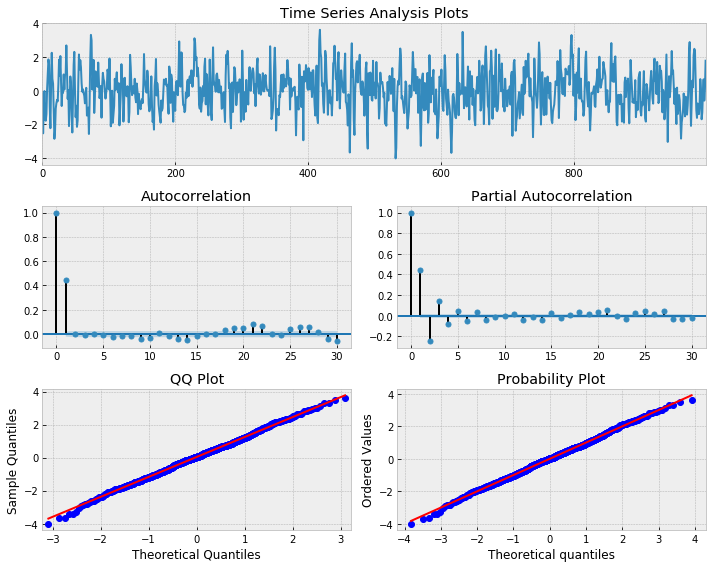

In [22]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

The ACF function shows that lag 1 is significant which indicates that a MA(1) model may be appropriate for our simulated series. I'm not sure how to interpret the PACF showing significance at lags 2, 3, and 4 when the ACF only shows significance at lag 1. Regardless we can now attempt to fit a MA(1) model to our simulated data. We can use the same statsmodels "ARMA()" function specifying our chosen orders. We call on its "fit()" method to return the model output. 

In [23]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1448.721
Method:                           mle   S.D. of innovations              1.030
Date:                Sun, 03 Dec 2017   AIC                           2901.441
Time:                        11:21:45   BIC                           2911.257
Sample:                             0   HQIC                          2905.172
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6158      0.026     23.947      0.000       0.565       0.666
                                    Roots                                    
                 Real           Imaginary           M

The model was able to correctly estimate the lag coefficent as 0.62 is close to our true value of 0.6. Also notice that our 95% confidence interval does contain the true value. Let's try simulating an MA(3)  process, then use our ARMA function to fit a third order MA model to the series and see if we can recover the correct lag coefficients (betas). Betas 1-3 are equal to 0.6, 0.4, and 0.2 respectively.

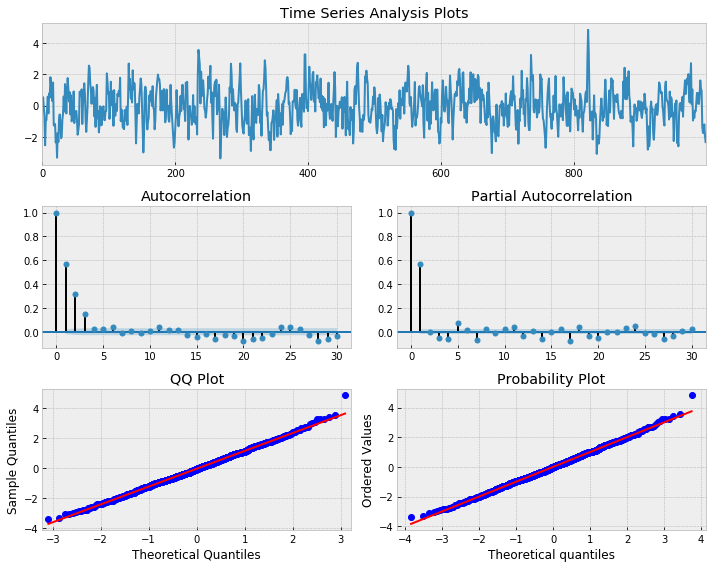

In [24]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [25]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1389.808
Method:                           mle   S.D. of innovations              0.971
Date:                Sun, 03 Dec 2017   AIC                           2787.616
Time:                        11:21:45   BIC                           2807.247
Sample:                             0   HQIC                          2795.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5673      0.031     18.393      0.000       0.507       0.628
ma.L2.y        0.3662      0.034     10.621      0.000       0.299       0.434
ma.L3.y        0.1966      0.030      6.539      0.0

The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.6, 0.4, and 0.3. Now let's try fitting an MA(3) model to the SPY's log returns. Keep in mind we do not know the true parameter values.

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.951
Method:                           mle   S.D. of innovations              0.014
Date:                Sun, 03 Dec 2017   AIC                         -11505.903
Time:                        11:21:45   BIC                         -11483.473
Sample:                    01-04-2007   HQIC                        -11497.670
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

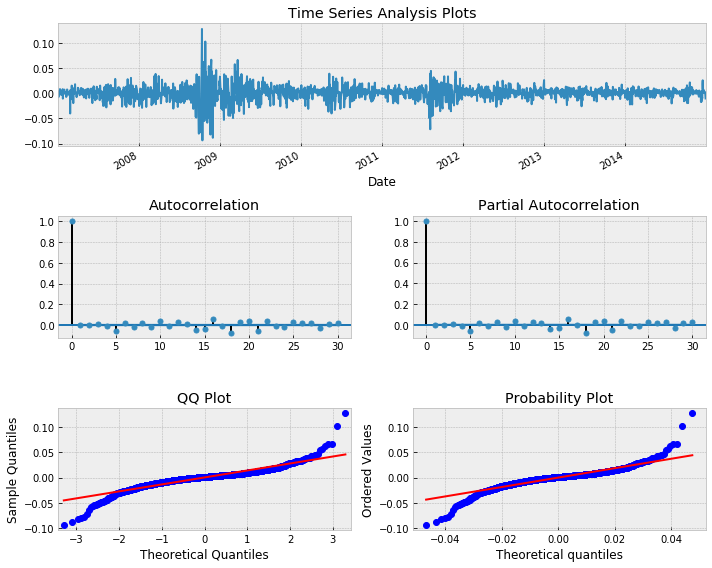

In [26]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

Not bad. Some of the ACF lags concern me especially at 5, 16, and 18. It could be sampling error but that combined with the heaviness of the tails makes me think this isn't the best model to predict future SPY returns.

## Autoregressive Moving Average Models - ARMA(p, q)

As you may have guessed, the ARMA model is simply the merger between AR(p) and MA(q) models. Let's recap what these models represent to us from a quant finance perspective: 

- AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets. 
- MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

The model formula is:

In [27]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/581bae46f5e23183493c6b53/1478209127534/?format=500w")

Let's simulate an ARMA(2, 2) process with given parameters, then fit an ARMA(2, 2) model and see if it can correctly estimate those parameters. Set alphas equal to [0.5,-0.25] and betas equal to [0.5,-0.3]. 

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7104.237
Method:                           mle   S.D. of innovations              1.002
Date:                Sun, 03 Dec 2017   AIC                          14218.474
Time:                        11:21:47   BIC                          14251.060
Sample:                             0   HQIC                         14229.895
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4849      0.049      9.905      0.000       0.389       0.581
ar.L2.y       -0.2647      0.015    -17.493      0.000      -0.294      -0.235
ma.L1.y        0.4990      0.050      9.988      0.0

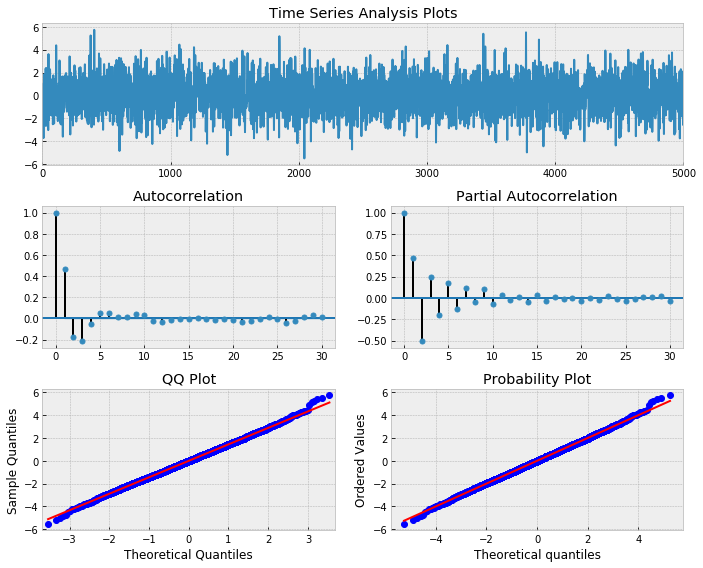

In [28]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

The model has correctly recovered our parameters, and our true parameters are contained within the 95% confidence interval.

Next we simulate a ARMA(3, 2) model. After, we cycle through a non trivial number of combinations of p, q to fit an ARMA model to our simulated series. We choose the best combination based on which model produces the lowest Akaike Information Criterion (AIC).

C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 14250.83208 | order: (4, 2)


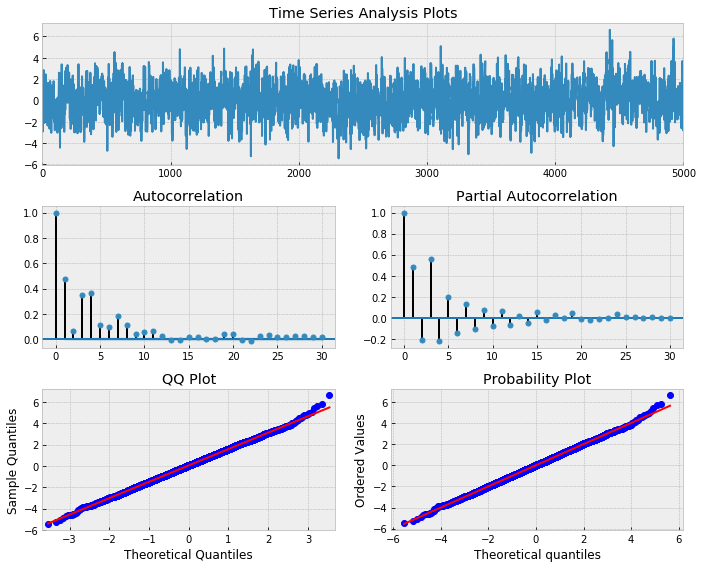

In [29]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: 14108.27213 | order: (3, 2)

Next we fit an ARMA model to SPY returns. The plot below is the time series before model fitting.

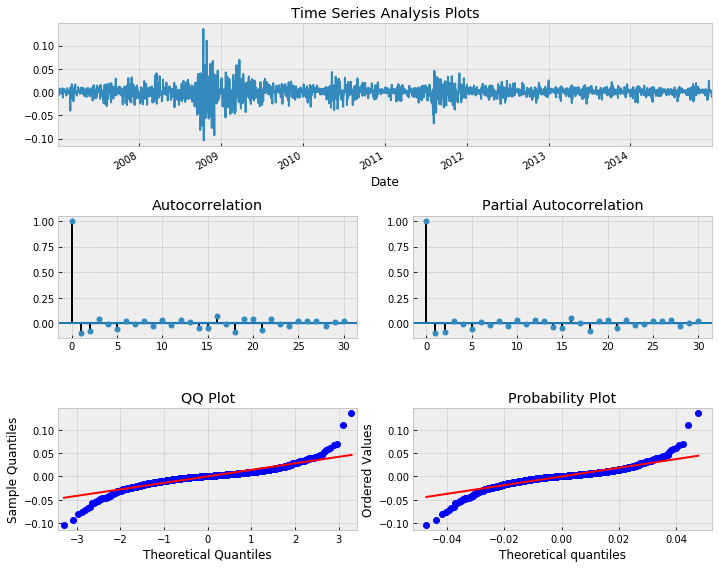

In [30]:
_ = tsplot(lrets['SPY'], lags=max_lag)

In [31]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -11518.22902 | order: (4, 4)

C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -11518.22862 | order: (4, 4)


C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
best_arma = smt.ARMA(lrets['SPY'], order=(4, 4)).fit(
                method='mle', trend='nc'
            )

C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


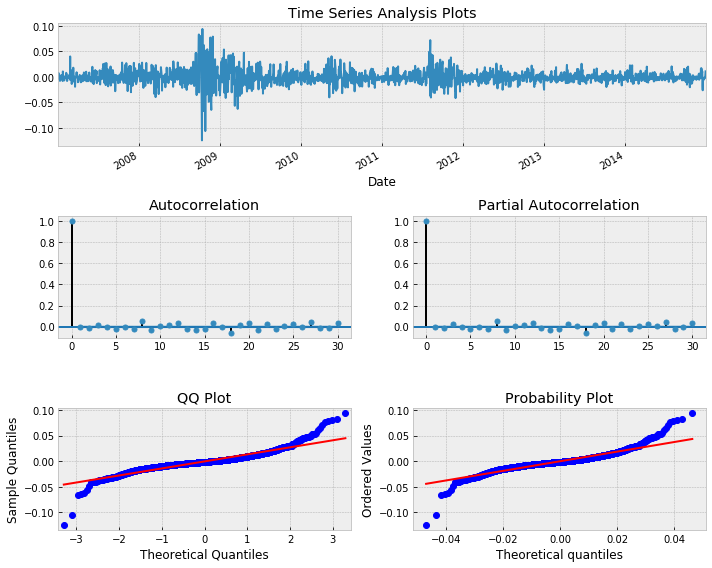

In [33]:
_ = tsplot(best_arma.predict() - lrets['SPY'], lags=max_lag)

The ACF and PACF are showing no significant autocorrelation. The QQ and Probability Plots show the residuals are approximately normal with heavy tails. However, this model's residuals do NOT look like white noise! Look at the highlighted areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured. 

## Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

ARIMA is a natural extension to the class of ARMA models. As previously mentioned many of our TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of a Guassian random walk and proved that it equals white noise. Said another way, we took the nonstationary random walk and transformed it to stationary white noise by first-differencing.

Without diving too deeply into the equation, just know the "d" references the number of times we are differencing the series. A side note, in Python we must use np.diff() function if we need to difference a series more than once. The pandas functions DataFrame.diff()/Series.diff() only takes the first difference of a dataframe/series and does not implement the recursive differencing needed in TSA.  

In the following example, we iterate through a non-trivial number of combinations of (p, d, q) orders, to find the best ARIMA model to fit SPY returns. We use the AIC to evaluate each model. The lowest AIC wins. 

C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

aic: -11518.22862 | order: (4, 0, 4)


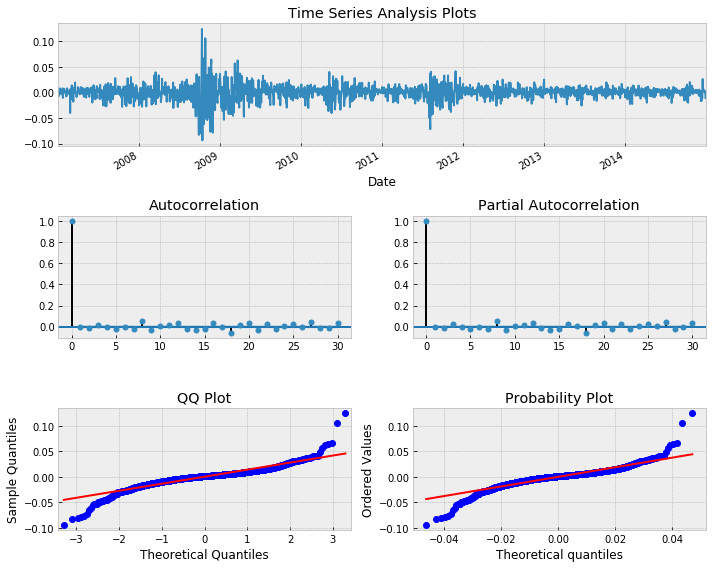

In [34]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

It should be no surprise that the best model has a differencing of 0. Recall that we already took the first difference of log prices to calculate the stock returns. Below, I plot the model residuals. The result is essentially identical to the ARMA(4, 4) model we fit above. **Clearly this ARIMA model has not explained the conditional volatility in the series either! **

Now we have at least accumulated enough knowledge to make a simple forecast of future returns. Here we make use of our model's forecast() method. As arguments, it takes an integer for the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [35]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001318,-0.025693,-0.034180,0.028328,0.036816
2015-01-01,-0.000034,-0.027165,-0.035690,0.027096,0.035621
2015-01-02,0.000427,-0.026747,-0.035286,0.027601,0.036140
2015-01-03,0.000641,-0.026533,-0.035072,0.027815,0.036353
2015-01-04,-0.000408,-0.027584,-0.036123,0.026769,0.035308


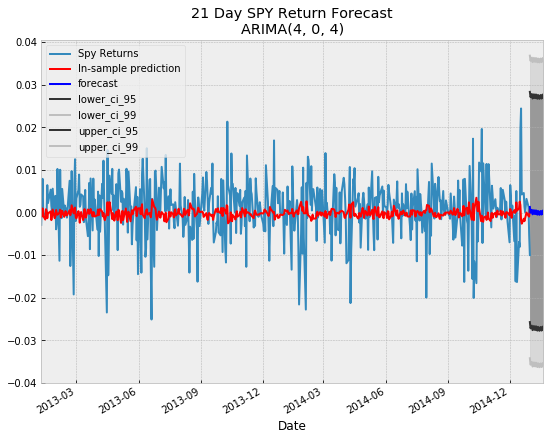

In [36]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

## Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series. Another way to think about it, is that the variance of our time series NOW at time t, is conditional on past observations of the variance in previous periods.

In [37]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/581d0b7129687f6b1d656b5f/1478298521147/?format=750w")

Assuming the series has zero mean we can express the model as:

In [38]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/581e5f886b8f5b2e554fb2b9/1478385643543/?format=750w")

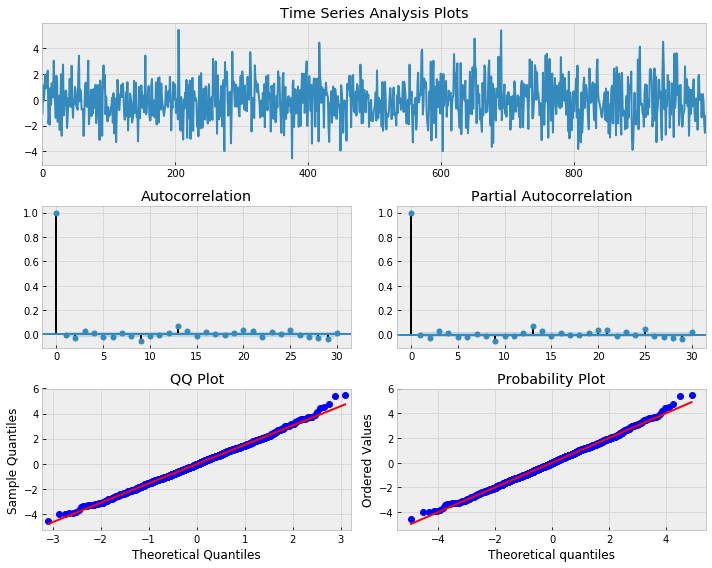

In [39]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

Simply put GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process. The basic GARCH(1, 1) formula is:

In [40]:
Image(url="https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/583e4fb59de4bb59518c4212/1480478686441/basic+GARCH%281%2C+1%29+formula_screenshot-www.quantstart.com-2016-11-08-13-06-09.png?format=1000w")

Omega (w) is white noise, and alpha and beta are parameters of the model. **Also alpha_1 + beta_1 must be less than 1 or the model is unstable**. We can simulate a GARCH(1, 1) process below.

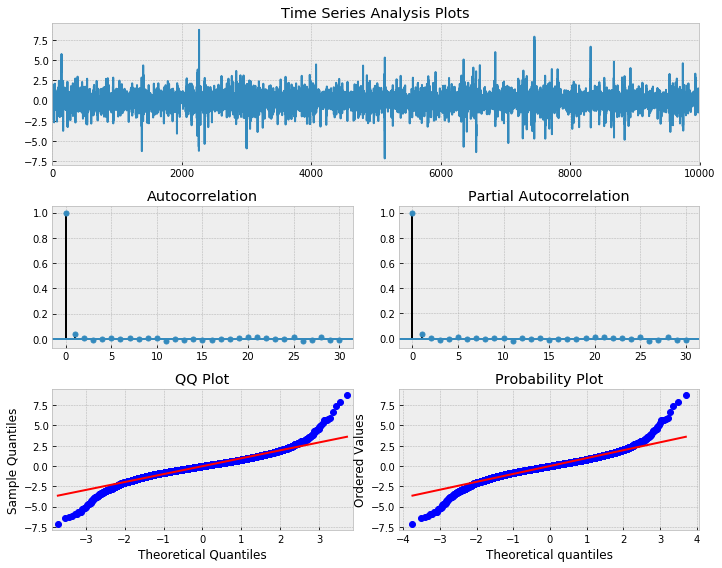

In [41]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

Again, notice that overall this process closely resembles white noise, however take a look when we view the squared eps series. 

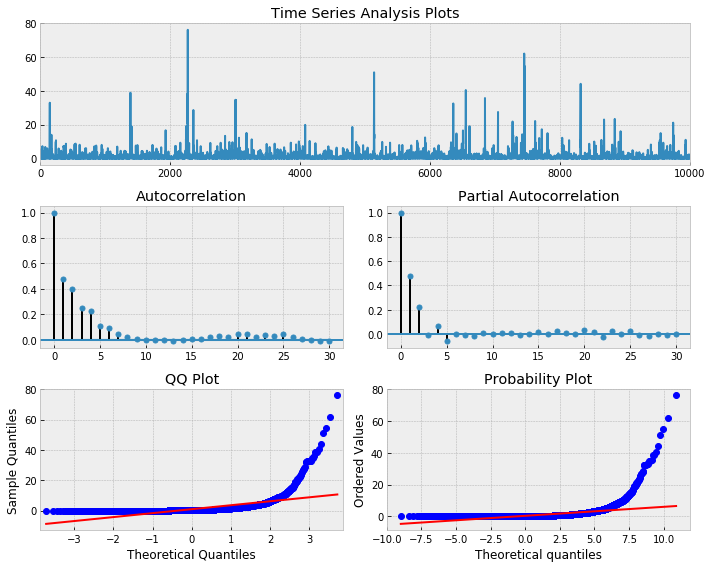

In [42]:
_ = tsplot(eps**2, lags=30)

There is clearly autocorrelation present and the significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model. Let's see if we can recover our process parameters using a GARCH(1, 1) model. Here we make use of the arch_model function from the ARCH package. 

In [43]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sun, Dec 03 2017   Df Residuals:                     9996
Time:      

Now let's run through an example using SPY returns. The process is as follows:

- Iterate through combinations of ARIMA(p, d, q) models to best fit our time series. 
- Pick the GARCH model orders according to the ARIMA model with lowest AIC.
- Fit the GARCH(p, q) model to our time series.
- Examine the model residuals and squared residuals for autocorrelation. 

Also note that I've chosen a specific time period to better highlight key points. However the results will be different depending on the time period under study. 

In [45]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

# aic: -5255.56673 | order: (3, 0, 2)

C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWar

aic: -5255.56619 | order: (3, 0, 2)


C:\Users\anton\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


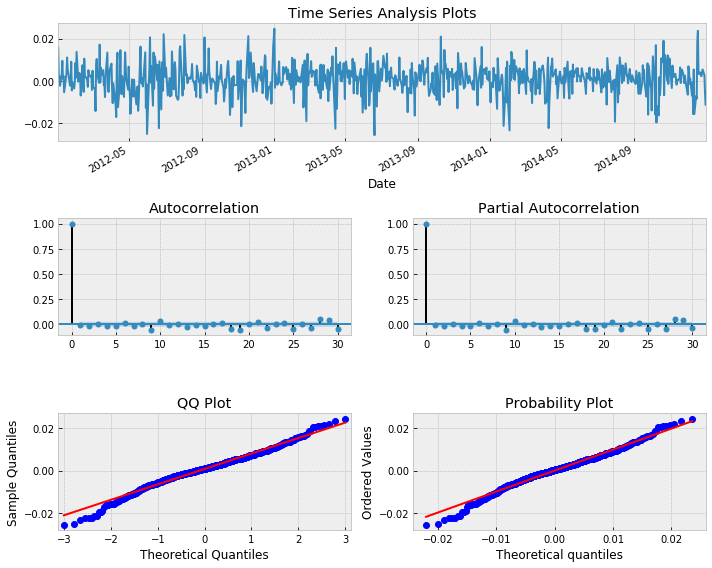

In [48]:
# ARIMA model resid plot
_ = tsplot(res_tup[2].resid, lags=30)

Looks like white noise. 

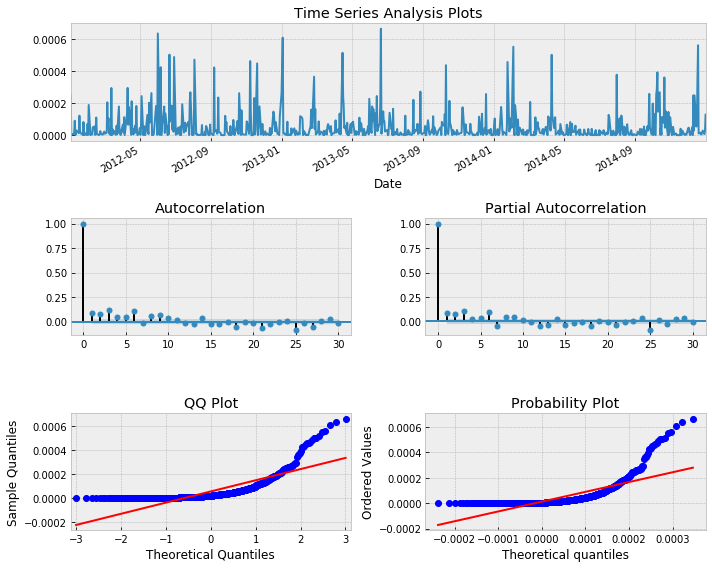

In [49]:
# ARIMA model resid plot
_ = tsplot(res_tup[2].resid**2, lags=30)

Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does.

In [53]:
order = res_tup[1]

In [54]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                     -17.839
Mean Model:                   Constant Mean   Adj. R-squared:                -17.839
Vol Model:                            GARCH   Log-Likelihood:                1395.11
Distribution:      Standardized Student's t   AIC:                          -2774.22
Method:                  Maximum Likelihood   BIC:                          -2737.22
                                              No. Observations:                  754
Date:                      Sun, Dec 03 2017   Df Residuals:                      746
Time:                              11:33:13   Df Model:                            8
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

C:\Users\anton\Anaconda3\lib\site-packages\arch\univariate\base.py:517: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


**Convergence warnings can occur when dealing with very small numbers. Multiplying the numbers by factors of 10 to scale the magnitude can help when necessary**, however for this demonstration it isn't necessary. Below are the model residuals. 

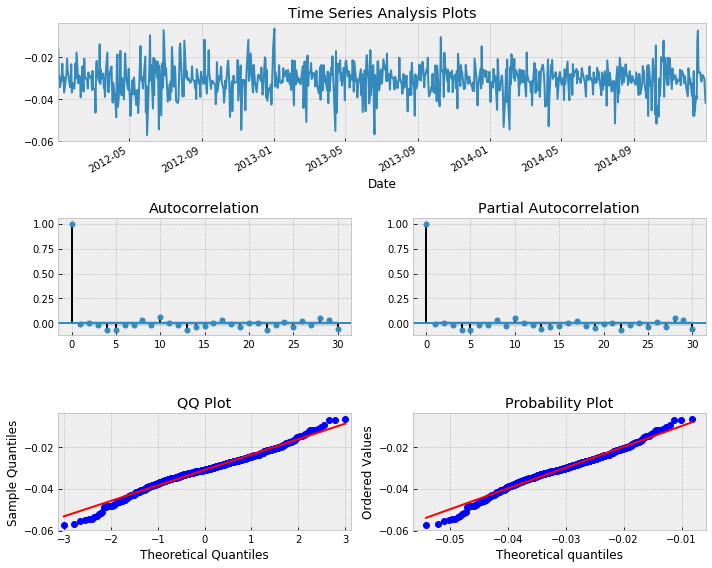

In [55]:
# ARIMA model resid plot
_ = tsplot(res.resid, lags=30)

Looks like white noise above. Now let's view the ACF and PACF of the squared residuals.

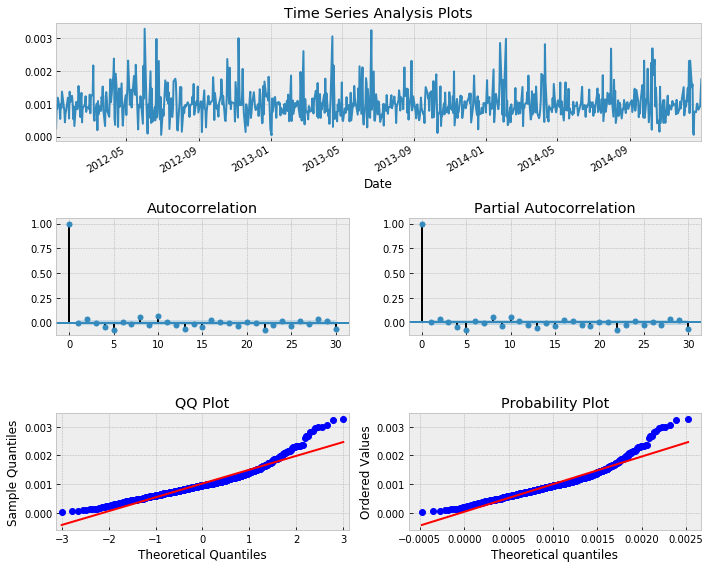

In [56]:
# ARIMA model resid plot
_ = tsplot(res.resid**2, lags=30)

Looks like we have achieved a good model fit as there is no obvious autocorrelation in the squared residuals.